$$
\newcommand{\mat}[1]{\boldsymbol {#1}}
\newcommand{\mattr}[1]{\boldsymbol {#1}^\top}
\newcommand{\matinv}[1]{\boldsymbol {#1}^{-1}}
\newcommand{\vec}[1]{\boldsymbol {#1}}
\newcommand{\vectr}[1]{\boldsymbol {#1}^\top}
\newcommand{\rvar}[1]{\mathrm {#1}}
\newcommand{\rvec}[1]{\boldsymbol{\mathrm{#1}}}
\newcommand{\diag}{\mathop{\mathrm {diag}}}
\newcommand{\set}[1]{\mathbb {#1}}
\newcommand{\norm}[1]{\left\lVert#1\right\rVert}
\newcommand{\pderiv}[2]{\frac{\partial #1}{\partial #2}}
\newcommand{\bm}[1]{{\bf #1}}
\newcommand{\bb}[1]{\bm{\mathrm{#1}}}
$$

# Part 3: Generative Adversarial Networks
<a id=part3></a>

In this part we will implement and train a generative adversarial network and apply it to the task of image generation.

In [3]:
import unittest
import os
import sys
import pathlib
import urllib
import shutil
import re
import zipfile

import numpy as np
import torch
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

test = unittest.TestCase()
plt.rcParams.update({'font.size': 12})
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cpu


### Obtaining the dataset
<a id=part3_1></a>

We'll use the same data as in Part 2.

But again, you can use a custom dataset, by editing the `PART3_CUSTOM_DATA_URL` variable in `hw3/answers.py`.

In [4]:
import cs236781.plot as plot
import cs236781.download
from hw3.answers import PART3_CUSTOM_DATA_URL as CUSTOM_DATA_URL

DATA_DIR = pathlib.Path.home().joinpath('.pytorch-datasets')
if CUSTOM_DATA_URL is None:
    DATA_URL = 'http://vis-www.cs.umass.edu/lfw/lfw-bush.zip'
else:
    DATA_URL = CUSTOM_DATA_URL

_, dataset_dir = cs236781.download.download_data(out_path=DATA_DIR, url=DATA_URL, extract=True, force=False)

File C:\Users\zidan\.pytorch-datasets\lfw-bush.zip exists, skipping download.
Extracting C:\Users\zidan\.pytorch-datasets\lfw-bush.zip...
Extracted 531 to C:\Users\zidan\.pytorch-datasets\lfw/George_W_Bush


Create a `Dataset` object that will load the extraced images:

In [5]:
import torchvision.transforms as T
from torchvision.datasets import ImageFolder

im_size = 64
tf = T.Compose([
    # Resize to constant spatial dimensions
    T.Resize((im_size, im_size)),
    # PIL.Image -> torch.Tensor
    T.ToTensor(),
    # Dynamic range [0,1] -> [-1, 1]
    T.Normalize(mean=(.5,.5,.5), std=(.5,.5,.5)),
])

ds_gwb = ImageFolder(os.path.dirname(dataset_dir), tf)

OK, let's see what we got. You can run the following block multiple times to display a random subset of images from the dataset.

Found 530 images in dataset folder.


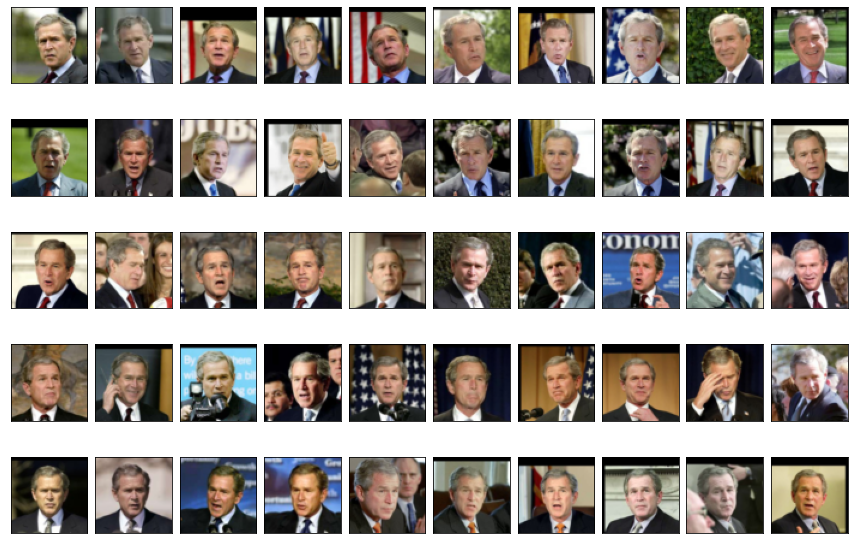

In [6]:
_ = plot.dataset_first_n(ds_gwb, 50, figsize=(15,10), nrows=5)
print(f'Found {len(ds_gwb)} images in dataset folder.')

In [7]:
x0, y0 = ds_gwb[0]
x0 = x0.unsqueeze(0).to(device)
print(x0.shape)

test.assertSequenceEqual(x0.shape, (1, 3, im_size, im_size))

torch.Size([1, 3, 64, 64])


## Generative Adversarial Nets (GANs)
<a id=part3_2></a>

GANs, first proposed in a [paper](https://arxiv.org/pdf/1406.2661.pdf) by Ian Goodfellow in 2014 are today arguably the most popular type of generative model. GANs are currently producing state of the art
results in generative tasks over many different domains.

In a GAN model, two different neural networks compete against each other: A **generator** and a **discriminator**.

- The Generator, which we'll denote as $\Psi _{\bb{\gamma}} : \mathcal{U} \rightarrow \mathcal{X}$, maps a latent-space variable
$\bb{u}\sim\mathcal{N}(\bb{0},\bb{I})$ to an instance-space variable $\bb{x}$ (e.g. an image).
Thus a parametric evidence distribution $p_{\bb{\gamma}}(\bb{X})$ is generated,
which we typically would like to be as close as possible to the real evidence distribution, $p(\bb{X})$.

- The Discriminator, $\Delta _{\bb{\delta}} : \mathcal{X} \rightarrow [0,1]$, is a network which,
given an instance-space variable $\bb{x}$, returns the  probability that $\bb{x}$ is real, i.e. that $\bb{x}$
was sampled from $p(\bb{X})$ and not $p_{\bb{\gamma}}(\bb{X})$.


<img src="imgs/gan.jpg" />

### Training GANs
<a id=part3_3></a>

The generator is trained to generate "fake" instances which will maximally fool the
discriminator into returning that they're real. Mathematically, the generator's parameters
$\bb{\gamma}$ should be chosen such as to **maximize** the expression
$$
\mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) )).
$$

The discriminator is trained to classify between real images, coming from the training set,
and fake images generated by the generator.
Mathematically, the discriminator's parameters $\bb{\delta}$ should be chosen such as to
**maximize** the expression
$$
\mathbb{E} _{\bb{x} \sim p(\bb{X}) } \log \Delta _{\bb{\delta}}(\bb{x})  \, + \,
\mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (1-\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) )).
$$

These two competing objectives can thus be expressed as the following min-max optimization:
$$
\min _{\bb{\gamma}} \max _{\bb{\delta}} \,
\mathbb{E} _{\bb{x} \sim p(\bb{X}) } \log \Delta _{\bb{\delta}}(\bb{x})  \, + \,
\mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (1-\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) )).
$$

A key insight into GANs is that we can interpret the above maximum as the *loss* with respect to
$\bb{\gamma}$:

$$
L({\bb{\gamma}}) =
\max _{\bb{\delta}} \, \mathbb{E} _{\bb{x} \sim p(\bb{X}) } \log \Delta _{\bb{\delta}}(\bb{x})  \, + \,
  \mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (1-\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) )).
$$

This means that the generator's loss function trains together with the generator
itself in an adversarial manner. In contrast, when training our VAE we used a fixed L2 norm
as a data loss term.

### Model Implementation
<a id=part3_4></a>

We'll now implement a Deep Convolutional GAN (DCGAN) model.
See the DCGAN [paper](https://arxiv.org/pdf/1511.06434.pdf) for architecture ideas and tips for training.

**TODO**: Implement the `Discriminator` class in the `hw3/gan.py` module.
If you wish you can reuse the `EncoderCNN` class from the VAE model as the first part of the Discriminator.

In [8]:
import hw3.gan as gan

dsc = gan.Discriminator(in_size=x0[0].shape).to(device)
print(dsc)

d0 = dsc(x0)
print(d0.shape)

test.assertSequenceEqual(d0.shape, (1,1))

Discriminator(
  (cnn): Sequential(
    (0): Conv2d(3, 128, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): Conv2d(128, 256, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Conv2d(256, 512, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2)
    (9): Conv2d(512, 1024, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (10): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.2)
  )
  (fc): Linear(in_features=16384, out_features=1, bias=True)
)
torch.Size([1, 1])


**TODO**: Implement the `Generator` class in the `hw3/gan.py` module.
If you wish you can reuse the `DecoderCNN` class from the VAE model as the last part of the Generator.

In [32]:
z_dim = 128
gen = gan.Generator(z_dim, 4).to(device)
print(gen)

z = torch.randn(1, z_dim).to(device)
xr = gen(z)
print(xr.shape)

test.assertSequenceEqual(x0.shape, xr.shape)

Generator(
  (cnn): Sequential(
    (0): ConvTranspose2d(1024, 512, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): ConvTranspose2d(512, 256, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): ConvTranspose2d(256, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): ConvTranspose2d(128, 3, kernel_size=(5, 5), stride=(2, 2), padding=(3, 3), output_padding=(1, 1))
    (10): Identity()
    (11): Identity()
  )
  (fc): Linear(in_features=128, out_features=16384, bias=True)
)
torch.Size([1, 3, 64, 64])


In [48]:
params = [p for p in gen.parameters()]
# print(torch.mean(params[3]))
print(params[4].shape)


torch.Size([512, 256, 5, 5])


### Loss Implementation
<a id=part3_5></a>

Let's begin with the discriminator's loss function.
Based on the above we can flip the sign and say we want to update the 
Discriminator's parameters $\bb{\delta}$ so that they **minimize** the expression
$$
- \mathbb{E} _{\bb{x} \sim p(\bb{X}) } \log \Delta _{\bb{\delta}}(\bb{x})  \, - \,
\mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (1-\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) )).
$$

We're using the Discriminator twice in this expression;
once to classify data from the real data distribution and
once again to classify generated data.
Therefore our loss should be computed based on these two terms.
Notice that since the discriminator returns a probability, we can formulate the above as two cross-entropy losses.

GANs are notoriously diffucult to train.
One common trick for improving GAN stability during training is to make the classification labels noisy for the discriminator. This can be seen as a form of regularization, to help prevent the discriminator from overfitting.

We'll incorporate this idea into our loss function. Instead of labels being equal to 0 or 1, we'll make them
"fuzzy", i.e. random numbers in the ranges $[0\pm\epsilon]$ and $[1\pm\epsilon]$.

**TODO**: Implement the `discriminator_loss_fn()` function in the `hw3/gan.py` module.

In [10]:
from hw3.gan import discriminator_loss_fn
torch.manual_seed(42)

y_data = torch.rand(10) * 10
y_generated = torch.rand(10) * 10

loss = discriminator_loss_fn(y_data, y_generated, data_label=1, label_noise=0.3)
print(loss)

test.assertAlmostEqual(loss.item(), 6.4808731, delta=1e-5)

tensor(6.4809)


Similarly, the generator's parameters $\bb{\gamma}$ should **minimize** the expression
$$
-\mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) ))
$$

which can also be seen as a cross-entropy term. This corresponds to "fooling" the discriminator; Notice that the gradient of the loss w.r.t $\bb{\gamma}$ using this expression also depends on $\bb{\delta}$.

**TODO**: Implement the `generator_loss_fn()` function in the `hw3/gan.py` module.

In [11]:
from hw3.gan import generator_loss_fn
torch.manual_seed(42)

y_generated = torch.rand(20) * 10

loss = generator_loss_fn(y_generated, data_label=1)
print(loss)

test.assertAlmostEqual(loss.item(), 0.0222969, delta=1e-3)

tensor(0.0223)


### Sampling
<a id=part3_6></a>

Sampling from a GAN is straightforward, since it learns to generate data from an isotropic Gaussian latent space distribution.

There is an important nuance however. Sampling is required during the process of training the GAN, since
we generate fake images to show the discriminator.
As you'll seen in the next section,  in some cases we'll need our samples to have gradients (i.e., to be part of
the Generator's computation graph).

**TODO**: Implement the `sample()` method in the `Generator` class within the `hw3/gan.py` module.

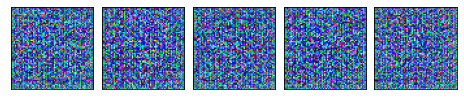

In [12]:
samples = gen.sample(5, with_grad=False)
test.assertSequenceEqual(samples.shape, (5, *x0.shape[1:]))
test.assertIsNone(samples.grad_fn)
_ = plot.tensors_as_images(samples.cpu())

samples = gen.sample(5, with_grad=True)
test.assertSequenceEqual(samples.shape, (5, *x0.shape[1:]))
test.assertIsNotNone(samples.grad_fn)

### Training
<a id=part3_7></a>

Training GANs is a bit different since we need to train two models simultaneously, each with it's own separate loss function and optimizer. We'll implement the training logic as a function that handles one batch of data
and updates both the discriminator and the generator based on it.

As mentioned above, GANs are considered hard to train. To get some ideas and tips you can see this [paper](https://arxiv.org/pdf/1606.03498.pdf), this list of ["GAN hacks"](https://github.com/soumith/ganhacks) or just do it the hard way :)

### Overfit Sanity Check

(<Figure size 432x288 with 1 Axes>, <AxesSubplot:>)

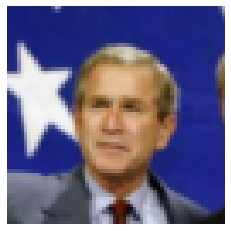

In [13]:
import torch.nn as nn
import torch.optim as optim
from hw3.training import VAETrainer
from torch.utils.data import DataLoader
# ds to memorize
ds_gwb_s = torch.utils.data.Subset(ds_gwb, range(1))
batch_size_ss = 1
dl_gwb_s = DataLoader(ds_gwb_s, batch_size=batch_size_ss, shuffle=False)
dl_iter = iter(dl_gwb_s)
x_overfit = next(dl_iter)
plot.tensor_as_image(x_overfit)

# _ = plot.dataset_first_n(ds_gwb_s, 4, figsize=(15,10))

In [25]:
import torch.optim as optim
from torch.utils.data import DataLoader
from hw3.answers import part3_gan_hyperparams

hp = part3_gan_hyperparams()
batch_size = hp['batch_size']
z_dim = hp['z_dim']
im_size = ds_gwb_s[0][0].shape

def create_optimizer(model_params, opt_params):
    opt_params = opt_params.copy()
    optimizer_type = opt_params['type']
    opt_params.pop('type')
    return optim.__dict__[optimizer_type](model_params, **opt_params)
    
dsc = gan.Discriminator(im_size).to(device)
gen = gan.Generator(z_dim, featuremap_size=4).to(device)

dsc_optimizer = create_optimizer(dsc.parameters(), hp['discriminator_optimizer'])
gen_optimizer = create_optimizer(gen.parameters(), hp['generator_optimizer'])



def dsc_loss_fn(y_data, y_generated):
    return gan.discriminator_loss_fn(y_data, y_generated, hp['data_label'], hp['label_noise'])

def gen_loss_fn(y_generated):
    return gan.generator_loss_fn(y_generated, hp['data_label'])

print(dsc)
print(gen)

Discriminator(
  (cnn): Sequential(
    (0): Conv2d(3, 128, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): Conv2d(128, 256, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Conv2d(256, 512, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2)
    (9): Conv2d(512, 1024, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (10): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.2)
  )
  (fc): Linear(in_features=16384, out_features=1, bias=True)
)
Generator(
  (cnn): Sequential(
    (0): ConvTranspose2d(1024, 512, ker

In [26]:
gen_optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.5, 0.99)
    eps: 1e-08
    lr: 0.0002
    weight_decay: 0
)

--- EPOCH 1/100 ---
  0%|          | 0/1 [00:00<?, ?it/s]
dsc_real_scores.item()=-0.36094897985458374, dsc_fake_scores.item()=-0.18483459949493408
100%|██████████| 1/1 [00:01<00:00,  1.08s/it]
Discriminator loss: 1.5161757469177246
Generator loss:     0.7041651606559753


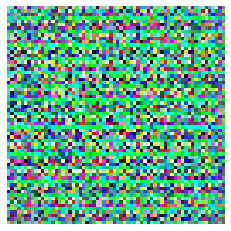

--- EPOCH 2/100 ---
  0%|          | 0/1 [00:00<?, ?it/s]
dsc_real_scores.item()=25.244688034057617, dsc_fake_scores.item()=0.32253387570381165
100%|██████████| 1/1 [00:01<00:00,  1.25s/it]
Discriminator loss: 0.17034912109375
Generator loss:     4.426019191741943


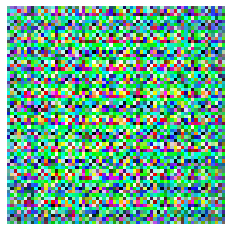

--- EPOCH 3/100 ---
  0%|          | 0/1 [00:00<?, ?it/s]
dsc_real_scores.item()=26.449121475219727, dsc_fake_scores.item()=-3.837045669555664
100%|██████████| 1/1 [00:01<00:00,  1.08s/it]
Discriminator loss: 2.0992345809936523
Generator loss:     8.315690994262695


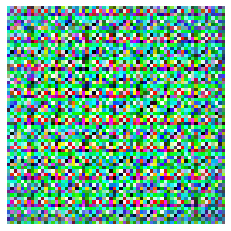

--- EPOCH 4/100 ---
  0%|          | 0/1 [00:00<?, ?it/s]
dsc_real_scores.item()=23.25019645690918, dsc_fake_scores.item()=-9.151726722717285
100%|██████████| 1/1 [00:01<00:00,  1.08s/it]
Discriminator loss: -1.5510963201522827
Generator loss:     9.238166809082031


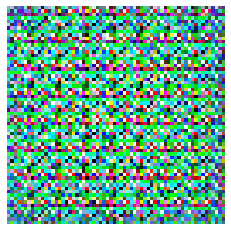

--- EPOCH 5/100 ---
  0%|          | 0/1 [00:00<?, ?it/s]
dsc_real_scores.item()=25.584964752197266, dsc_fake_scores.item()=-4.012306213378906
100%|██████████| 1/1 [00:01<00:00,  1.05s/it]
Discriminator loss: -0.7466598153114319
Generator loss:     1.7451891899108887


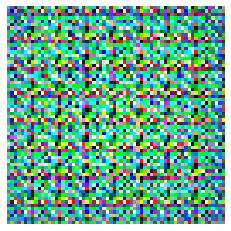

--- EPOCH 6/100 ---
  0%|          | 0/1 [00:00<?, ?it/s]
dsc_real_scores.item()=28.292953491210938, dsc_fake_scores.item()=4.01580286026001
100%|██████████| 1/1 [00:01<00:00,  1.07s/it]
Discriminator loss: 2.7321643829345703
Generator loss:     15.883577346801758


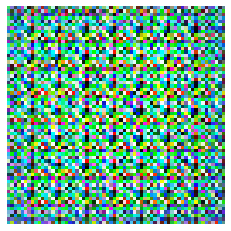

--- EPOCH 7/100 ---
  0%|          | 0/1 [00:00<?, ?it/s]
dsc_real_scores.item()=27.14468002319336, dsc_fake_scores.item()=-10.7615385055542
100%|██████████| 1/1 [00:01<00:00,  1.08s/it]
Discriminator loss: -1.370064377784729
Generator loss:     15.546826362609863


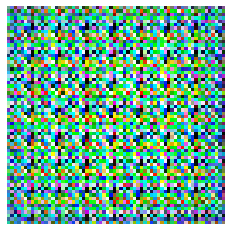

--- EPOCH 8/100 ---
  0%|          | 0/1 [00:00<?, ?it/s]
dsc_real_scores.item()=27.582115173339844, dsc_fake_scores.item()=-17.05876350402832
100%|██████████| 1/1 [00:01<00:00,  1.09s/it]
Discriminator loss: -2.52311372756958
Generator loss:     3.0218989849090576


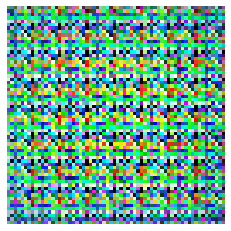

--- EPOCH 9/100 ---
  0%|          | 0/1 [00:00<?, ?it/s]
dsc_real_scores.item()=30.15454864501953, dsc_fake_scores.item()=0.2546485364437103
100%|██████████| 1/1 [00:01<00:00,  1.10s/it]
Discriminator loss: 0.3555586040019989
Generator loss:     21.660371780395508


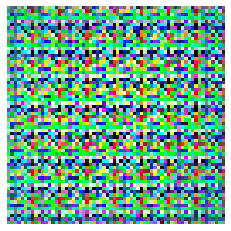

--- EPOCH 10/100 ---
  0%|          | 0/1 [00:00<?, ?it/s]
dsc_real_scores.item()=28.961645126342773, dsc_fake_scores.item()=-15.905510902404785
100%|██████████| 1/1 [00:01<00:00,  1.04s/it]
Discriminator loss: 1.3012053966522217
Generator loss:     18.169376373291016


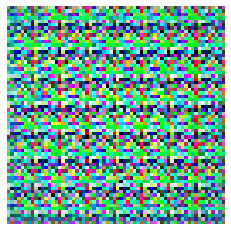

--- EPOCH 11/100 ---
  0%|          | 0/1 [00:00<?, ?it/s]
dsc_real_scores.item()=27.368093490600586, dsc_fake_scores.item()=-20.541784286499023
100%|██████████| 1/1 [00:01<00:00,  1.10s/it]
Discriminator loss: 2.268676280975342
Generator loss:     14.975632667541504


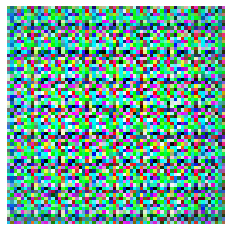

--- EPOCH 12/100 ---
  0%|          | 0/1 [00:00<?, ?it/s]
dsc_real_scores.item()=20.84164047241211, dsc_fake_scores.item()=-7.873545169830322
100%|██████████| 1/1 [00:01<00:00,  1.16s/it]
Discriminator loss: 2.2760419845581055
Generator loss:     18.76503562927246


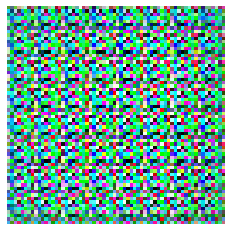

--- EPOCH 13/100 ---
  0%|          | 0/1 [00:00<?, ?it/s]
dsc_real_scores.item()=9.902584075927734, dsc_fake_scores.item()=-12.995208740234375
100%|██████████| 1/1 [00:01<00:00,  1.08s/it]
Discriminator loss: -0.21037441492080688
Generator loss:     11.83889389038086


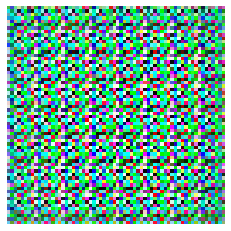

--- EPOCH 14/100 ---
  0%|          | 0/1 [00:00<?, ?it/s]
dsc_real_scores.item()=15.669508934020996, dsc_fake_scores.item()=-10.829729080200195
100%|██████████| 1/1 [00:01<00:00,  1.19s/it]
Discriminator loss: -1.353912115097046
Generator loss:     3.0970895290374756


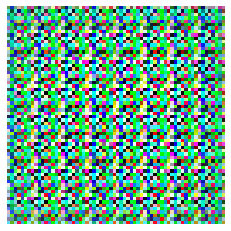

--- EPOCH 15/100 ---
  0%|          | 0/1 [00:00<?, ?it/s]
dsc_real_scores.item()=20.569263458251953, dsc_fake_scores.item()=-13.388023376464844
100%|██████████| 1/1 [00:01<00:00,  1.11s/it]
Discriminator loss: -2.062298536300659
Generator loss:     3.7837767601013184


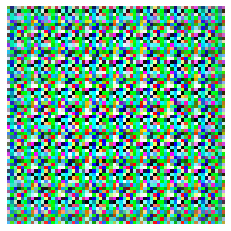

--- EPOCH 16/100 ---
  0%|          | 0/1 [00:00<?, ?it/s]
dsc_real_scores.item()=24.89449691772461, dsc_fake_scores.item()=-17.1800537109375
100%|██████████| 1/1 [00:01<00:00,  1.11s/it]
Discriminator loss: 0.7642273902893066
Generator loss:     3.292078971862793


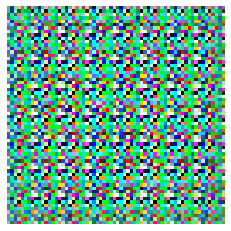

--- EPOCH 17/100 ---
  0%|          | 0/1 [00:00<?, ?it/s]
dsc_real_scores.item()=22.73969268798828, dsc_fake_scores.item()=-9.635873794555664
100%|██████████| 1/1 [00:01<00:00,  1.17s/it]
Discriminator loss: 0.14201277494430542
Generator loss:     3.3112032413482666


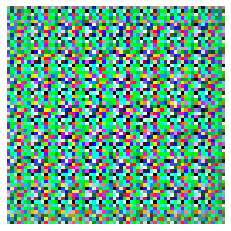

--- EPOCH 18/100 ---
  0%|          | 0/1 [00:00<?, ?it/s]
dsc_real_scores.item()=23.580415725708008, dsc_fake_scores.item()=1.3829824924468994
100%|██████████| 1/1 [00:01<00:00,  1.07s/it]
Discriminator loss: 3.8239059448242188
Generator loss:     21.972915649414062


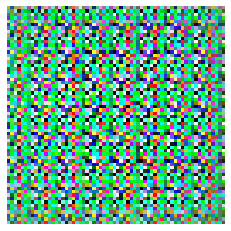

--- EPOCH 19/100 ---
  0%|          | 0/1 [00:00<?, ?it/s]
dsc_real_scores.item()=16.212688446044922, dsc_fake_scores.item()=-21.44260597229004
100%|██████████| 1/1 [00:01<00:00,  1.10s/it]
Discriminator loss: 2.9463367462158203
Generator loss:     25.718353271484375


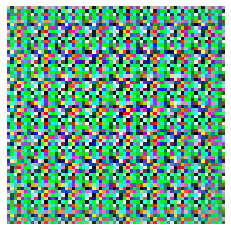

--- EPOCH 20/100 ---
  0%|          | 0/1 [00:00<?, ?it/s]
dsc_real_scores.item()=8.841177940368652, dsc_fake_scores.item()=-22.15645980834961
100%|██████████| 1/1 [00:01<00:00,  1.07s/it]
Discriminator loss: -0.674892008304596
Generator loss:     28.880435943603516


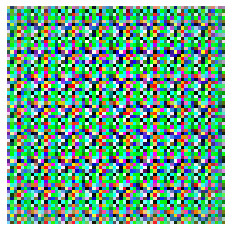

--- EPOCH 21/100 ---
  0%|          | 0/1 [00:00<?, ?it/s]
dsc_real_scores.item()=5.440997123718262, dsc_fake_scores.item()=-23.77839469909668
100%|██████████| 1/1 [00:01<00:00,  1.11s/it]
Discriminator loss: 1.6093024015426636
Generator loss:     24.009777069091797


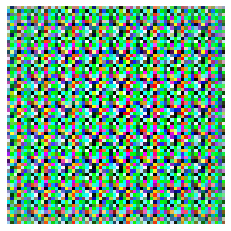

--- EPOCH 22/100 ---
  0%|          | 0/1 [00:00<?, ?it/s]
dsc_real_scores.item()=5.405245780944824, dsc_fake_scores.item()=-29.70941925048828
100%|██████████| 1/1 [00:01<00:00,  1.12s/it]
Discriminator loss: 3.1901063919067383
Generator loss:     20.971256256103516


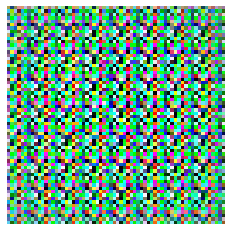

--- EPOCH 23/100 ---
  0%|          | 0/1 [00:00<?, ?it/s]
dsc_real_scores.item()=1.6413885354995728, dsc_fake_scores.item()=-22.397733688354492
100%|██████████| 1/1 [00:01<00:00,  1.09s/it]
Discriminator loss: 0.33149728178977966
Generator loss:     20.800039291381836


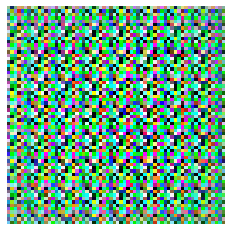

--- EPOCH 24/100 ---
  0%|          | 0/1 [00:00<?, ?it/s]
dsc_real_scores.item()=10.961211204528809, dsc_fake_scores.item()=-18.174686431884766
100%|██████████| 1/1 [00:01<00:00,  1.12s/it]
Discriminator loss: 0.8581599593162537
Generator loss:     10.586644172668457


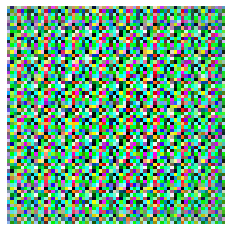

--- EPOCH 25/100 ---
  0%|          | 0/1 [00:00<?, ?it/s]
dsc_real_scores.item()=14.989872932434082, dsc_fake_scores.item()=-17.81553077697754
100%|██████████| 1/1 [00:01<00:00,  1.13s/it]
Discriminator loss: -2.339261293411255
Generator loss:     21.842411041259766


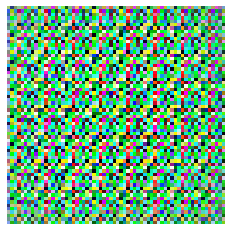

--- EPOCH 26/100 ---
  0%|          | 0/1 [00:00<?, ?it/s]
dsc_real_scores.item()=19.363845825195312, dsc_fake_scores.item()=-14.528437614440918
100%|██████████| 1/1 [00:01<00:00,  1.22s/it]
Discriminator loss: 1.2870941162109375
Generator loss:     2.867750644683838


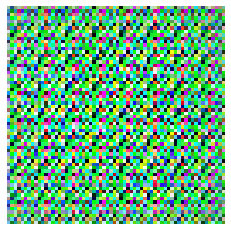

--- EPOCH 27/100 ---
  0%|          | 0/1 [00:00<?, ?it/s]
dsc_real_scores.item()=20.669553756713867, dsc_fake_scores.item()=-9.156842231750488
100%|██████████| 1/1 [00:01<00:00,  1.14s/it]
Discriminator loss: -0.9086201190948486
Generator loss:     0.02501155436038971


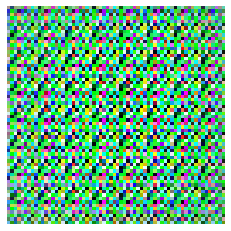

--- EPOCH 28/100 ---
  0%|          | 0/1 [00:00<?, ?it/s]
dsc_real_scores.item()=21.48530387878418, dsc_fake_scores.item()=-12.995200157165527
100%|██████████| 1/1 [00:01<00:00,  1.11s/it]
Discriminator loss: -1.1434299945831299
Generator loss:     1.6203734874725342


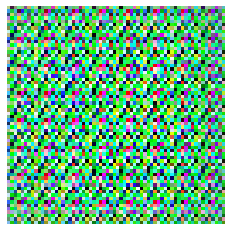

--- EPOCH 29/100 ---
  0%|          | 0/1 [00:00<?, ?it/s]
dsc_real_scores.item()=22.751611709594727, dsc_fake_scores.item()=-9.48079776763916
100%|██████████| 1/1 [00:01<00:00,  1.14s/it]
Discriminator loss: -0.49202704429626465
Generator loss:     31.266998291015625


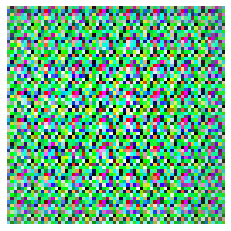

--- EPOCH 30/100 ---
  0%|          | 0/1 [00:00<?, ?it/s]
dsc_real_scores.item()=24.131160736083984, dsc_fake_scores.item()=3.929100751876831
100%|██████████| 1/1 [00:01<00:00,  1.23s/it]
Discriminator loss: 6.369743347167969
Generator loss:     26.028596878051758


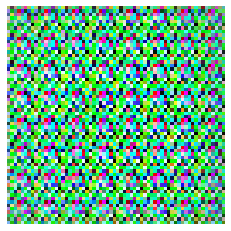

--- EPOCH 31/100 ---
  0%|          | 0/1 [00:00<?, ?it/s]
dsc_real_scores.item()=16.398101806640625, dsc_fake_scores.item()=-24.990018844604492
100%|██████████| 1/1 [00:01<00:00,  1.20s/it]
Discriminator loss: -0.8438079357147217
Generator loss:     24.744022369384766


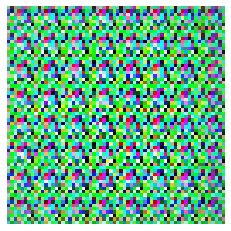

--- EPOCH 32/100 ---
  0%|          | 0/1 [00:00<?, ?it/s]
dsc_real_scores.item()=14.546189308166504, dsc_fake_scores.item()=-25.30323600769043
100%|██████████| 1/1 [00:01<00:00,  1.12s/it]
Discriminator loss: 1.0077465772628784
Generator loss:     28.45622444152832


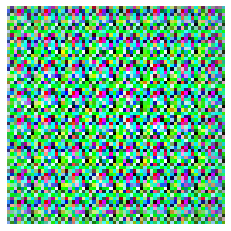

--- EPOCH 33/100 ---
  0%|          | 0/1 [00:00<?, ?it/s]
dsc_real_scores.item()=17.84171485900879, dsc_fake_scores.item()=-27.92386245727539
100%|██████████| 1/1 [00:01<00:00,  1.31s/it]
Discriminator loss: -3.6053481101989746
Generator loss:     27.396190643310547


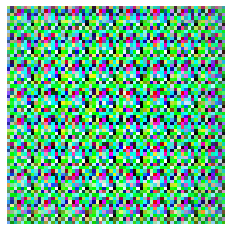

--- EPOCH 34/100 ---
  0%|          | 0/1 [00:00<?, ?it/s]
dsc_real_scores.item()=22.486406326293945, dsc_fake_scores.item()=-27.76123046875
100%|██████████| 1/1 [00:01<00:00,  1.21s/it]
Discriminator loss: -1.9667863845825195
Generator loss:     24.737895965576172


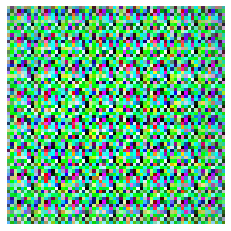

--- EPOCH 35/100 ---
  0%|          | 0/1 [00:00<?, ?it/s]
dsc_real_scores.item()=24.395273208618164, dsc_fake_scores.item()=-27.763471603393555
100%|██████████| 1/1 [00:01<00:00,  1.21s/it]
Discriminator loss: 2.587315797805786
Generator loss:     30.53884506225586


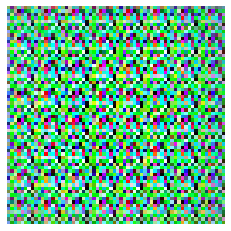

--- EPOCH 36/100 ---
  0%|          | 0/1 [00:00<?, ?it/s]
dsc_real_scores.item()=23.966171264648438, dsc_fake_scores.item()=-24.6123046875
100%|██████████| 1/1 [00:01<00:00,  1.18s/it]
Discriminator loss: 0.2710916996002197
Generator loss:     22.82732582092285


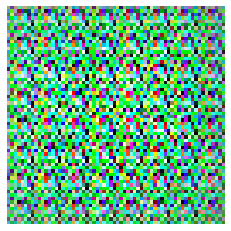

--- EPOCH 37/100 ---
  0%|          | 0/1 [00:00<?, ?it/s]
dsc_real_scores.item()=25.26237678527832, dsc_fake_scores.item()=-23.862850189208984
100%|██████████| 1/1 [00:01<00:00,  1.16s/it]
Discriminator loss: 2.0067129135131836
Generator loss:     21.76619529724121


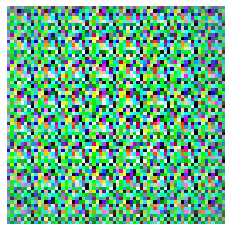

--- EPOCH 38/100 ---
  0%|          | 0/1 [00:00<?, ?it/s]
dsc_real_scores.item()=24.284482955932617, dsc_fake_scores.item()=-25.95404624938965
100%|██████████| 1/1 [00:01<00:00,  1.16s/it]
Discriminator loss: 4.252289295196533
Generator loss:     23.138254165649414


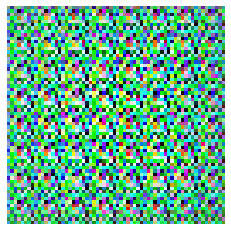

--- EPOCH 39/100 ---
  0%|          | 0/1 [00:00<?, ?it/s]
dsc_real_scores.item()=22.015867233276367, dsc_fake_scores.item()=-15.55190658569336
100%|██████████| 1/1 [00:01<00:00,  1.16s/it]
Discriminator loss: -0.6799519062042236
Generator loss:     12.204577445983887


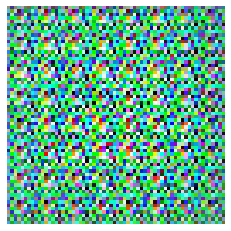

--- EPOCH 40/100 ---
  0%|          | 0/1 [00:00<?, ?it/s]
dsc_real_scores.item()=22.372591018676758, dsc_fake_scores.item()=-12.16236400604248
100%|██████████| 1/1 [00:01<00:00,  1.16s/it]
Discriminator loss: -0.1596740484237671
Generator loss:     14.984956741333008


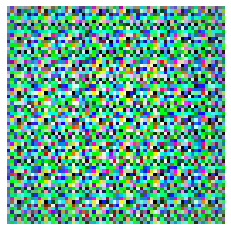

--- EPOCH 41/100 ---
  0%|          | 0/1 [00:00<?, ?it/s]
dsc_real_scores.item()=23.560619354248047, dsc_fake_scores.item()=-23.902935028076172
100%|██████████| 1/1 [00:01<00:00,  1.18s/it]
Discriminator loss: 0.17985430359840393
Generator loss:     3.3574211597442627


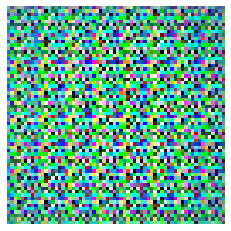

--- EPOCH 42/100 ---
  0%|          | 0/1 [00:00<?, ?it/s]
dsc_real_scores.item()=24.534311294555664, dsc_fake_scores.item()=-3.260293483734131
100%|██████████| 1/1 [00:01<00:00,  1.16s/it]
Discriminator loss: -1.463752031326294
Generator loss:     10.359867095947266


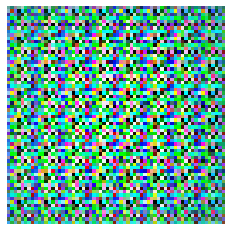

--- EPOCH 43/100 ---
  0%|          | 0/1 [00:00<?, ?it/s]
dsc_real_scores.item()=26.392868041992188, dsc_fake_scores.item()=-17.511743545532227
100%|██████████| 1/1 [00:01<00:00,  1.17s/it]
Discriminator loss: 1.9889850616455078
Generator loss:     7.883543491363525


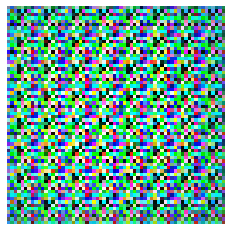

--- EPOCH 44/100 ---
  0%|          | 0/1 [00:00<?, ?it/s]
dsc_real_scores.item()=26.79363441467285, dsc_fake_scores.item()=0.017936332151293755
100%|██████████| 1/1 [00:01<00:00,  1.30s/it]
Discriminator loss: 2.5246710777282715
Generator loss:     15.765260696411133


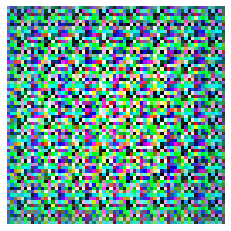

--- EPOCH 45/100 ---
  0%|          | 0/1 [00:00<?, ?it/s]
dsc_real_scores.item()=21.21877098083496, dsc_fake_scores.item()=-24.19041633605957
100%|██████████| 1/1 [00:01<00:00,  1.17s/it]
Discriminator loss: 1.4969385862350464
Generator loss:     27.842575073242188


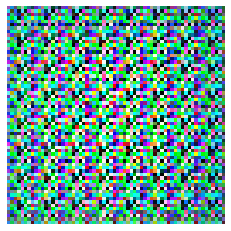

--- EPOCH 46/100 ---
  0%|          | 0/1 [00:00<?, ?it/s]
dsc_real_scores.item()=17.7092342376709, dsc_fake_scores.item()=-24.877487182617188
100%|██████████| 1/1 [00:01<00:00,  1.49s/it]
Discriminator loss: -2.5166187286376953
Generator loss:     19.43472671508789


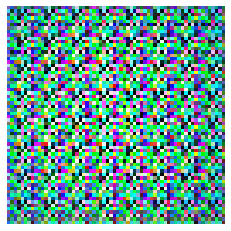

--- EPOCH 47/100 ---
  0%|          | 0/1 [00:00<?, ?it/s]
dsc_real_scores.item()=19.2828426361084, dsc_fake_scores.item()=-24.220304489135742
100%|██████████| 1/1 [00:01<00:00,  1.81s/it]
Discriminator loss: -0.6536514163017273
Generator loss:     24.927486419677734


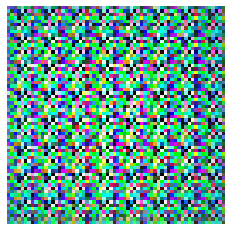

--- EPOCH 48/100 ---
  0%|          | 0/1 [00:00<?, ?it/s]
dsc_real_scores.item()=20.87009048461914, dsc_fake_scores.item()=-14.958075523376465
100%|██████████| 1/1 [00:01<00:00,  1.20s/it]
Discriminator loss: -0.2706838846206665
Generator loss:     25.84082794189453


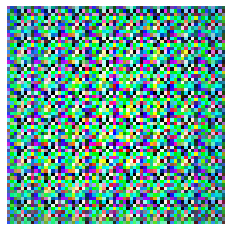

--- EPOCH 49/100 ---
  0%|          | 0/1 [00:00<?, ?it/s]
dsc_real_scores.item()=19.718122482299805, dsc_fake_scores.item()=-21.518497467041016
100%|██████████| 1/1 [00:01<00:00,  1.16s/it]
Discriminator loss: -1.584237813949585
Generator loss:     21.253488540649414


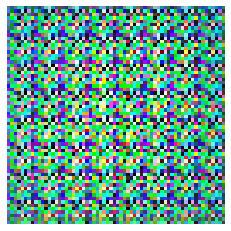

--- EPOCH 50/100 ---
  0%|          | 0/1 [00:00<?, ?it/s]
dsc_real_scores.item()=21.68592071533203, dsc_fake_scores.item()=-28.39618682861328
100%|██████████| 1/1 [00:01<00:00,  1.27s/it]
Discriminator loss: 2.9007110595703125
Generator loss:     21.189029693603516


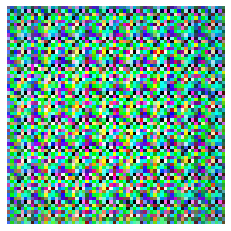

--- EPOCH 51/100 ---
  0%|          | 0/1 [00:00<?, ?it/s]
dsc_real_scores.item()=20.863040924072266, dsc_fake_scores.item()=-24.17123794555664
100%|██████████| 1/1 [00:01<00:00,  1.29s/it]
Discriminator loss: -1.4053250551223755
Generator loss:     23.959367752075195


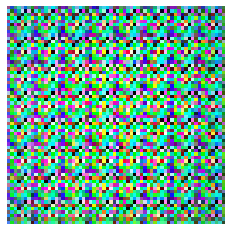

--- EPOCH 52/100 ---
  0%|          | 0/1 [00:00<?, ?it/s]
dsc_real_scores.item()=23.229747772216797, dsc_fake_scores.item()=-18.98777961730957
100%|██████████| 1/1 [00:01<00:00,  1.12s/it]
Discriminator loss: -0.45082908868789673
Generator loss:     20.55860710144043


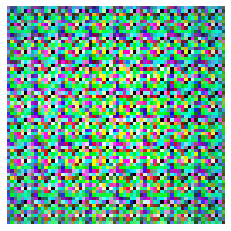

--- EPOCH 53/100 ---
  0%|          | 0/1 [00:00<?, ?it/s]
dsc_real_scores.item()=24.99842643737793, dsc_fake_scores.item()=-15.966347694396973
100%|██████████| 1/1 [00:01<00:00,  1.22s/it]
Discriminator loss: 3.2711901664733887
Generator loss:     22.25149917602539


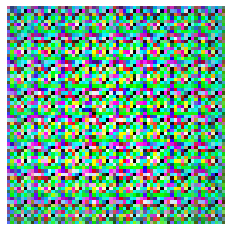

--- EPOCH 54/100 ---
  0%|          | 0/1 [00:00<?, ?it/s]
dsc_real_scores.item()=23.681774139404297, dsc_fake_scores.item()=-19.539487838745117
100%|██████████| 1/1 [00:01<00:00,  1.40s/it]
Discriminator loss: 0.6466129422187805
Generator loss:     13.869784355163574


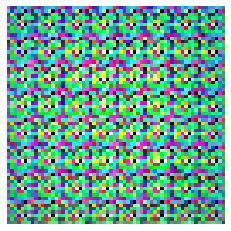

--- EPOCH 55/100 ---
  0%|          | 0/1 [00:00<?, ?it/s]
dsc_real_scores.item()=22.025741577148438, dsc_fake_scores.item()=-20.15280532836914
100%|██████████| 1/1 [00:01<00:00,  1.30s/it]
Discriminator loss: 1.6984442472457886
Generator loss:     18.03965950012207


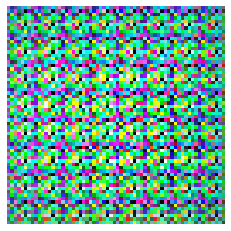

--- EPOCH 56/100 ---
  0%|          | 0/1 [00:00<?, ?it/s]
dsc_real_scores.item()=19.490934371948242, dsc_fake_scores.item()=-17.4501953125
100%|██████████| 1/1 [00:01<00:00,  1.28s/it]
Discriminator loss: -1.3280023336410522
Generator loss:     6.612049579620361


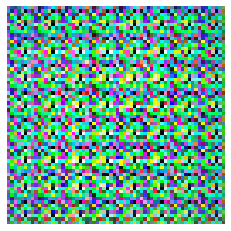

--- EPOCH 57/100 ---
  0%|          | 0/1 [00:00<?, ?it/s]
dsc_real_scores.item()=20.185462951660156, dsc_fake_scores.item()=-11.080917358398438
100%|██████████| 1/1 [00:01<00:00,  1.17s/it]
Discriminator loss: 0.5173889398574829
Generator loss:     22.641399383544922


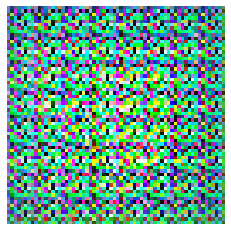

--- EPOCH 58/100 ---
  0%|          | 0/1 [00:00<?, ?it/s]
dsc_real_scores.item()=20.7003116607666, dsc_fake_scores.item()=-7.423137664794922
100%|██████████| 1/1 [00:01<00:00,  1.23s/it]
Discriminator loss: -0.4472053050994873
Generator loss:     6.883100509643555


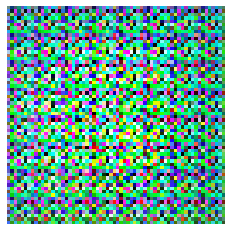

--- EPOCH 59/100 ---
  0%|          | 0/1 [00:00<?, ?it/s]
dsc_real_scores.item()=20.380939483642578, dsc_fake_scores.item()=-25.05101776123047
100%|██████████| 1/1 [00:01<00:00,  1.24s/it]
Discriminator loss: 2.022505760192871
Generator loss:     16.171159744262695


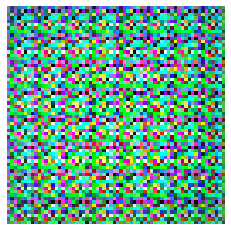

--- EPOCH 60/100 ---
  0%|          | 0/1 [00:00<?, ?it/s]
dsc_real_scores.item()=19.766407012939453, dsc_fake_scores.item()=-2.3923447132110596
100%|██████████| 1/1 [00:01<00:00,  1.46s/it]
Discriminator loss: 1.5012775659561157
Generator loss:     17.666406631469727


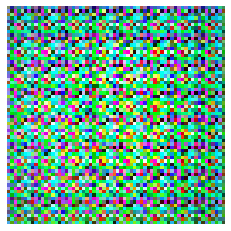

--- EPOCH 61/100 ---
  0%|          | 0/1 [00:00<?, ?it/s]
dsc_real_scores.item()=17.343610763549805, dsc_fake_scores.item()=-8.850749969482422
100%|██████████| 1/1 [00:01<00:00,  1.16s/it]
Discriminator loss: 0.5481364727020264
Generator loss:     8.862499237060547


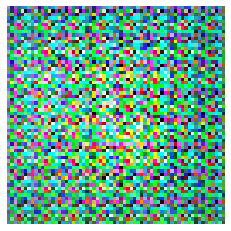

--- EPOCH 62/100 ---
  0%|          | 0/1 [00:00<?, ?it/s]
dsc_real_scores.item()=12.456437110900879, dsc_fake_scores.item()=-24.687379837036133
100%|██████████| 1/1 [00:01<00:00,  1.19s/it]
Discriminator loss: -1.991624116897583
Generator loss:     17.922639846801758


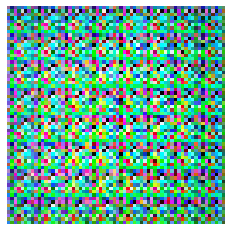

--- EPOCH 63/100 ---
  0%|          | 0/1 [00:00<?, ?it/s]
dsc_real_scores.item()=11.929696083068848, dsc_fake_scores.item()=-15.103009223937988
100%|██████████| 1/1 [00:01<00:00,  1.14s/it]
Discriminator loss: -1.723564624786377
Generator loss:     22.941987991333008


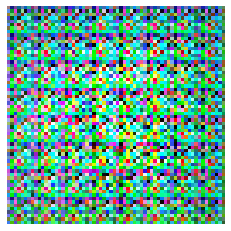

--- EPOCH 64/100 ---
  0%|          | 0/1 [00:00<?, ?it/s]
dsc_real_scores.item()=13.768240928649902, dsc_fake_scores.item()=-24.798564910888672
100%|██████████| 1/1 [00:01<00:00,  1.32s/it]
Discriminator loss: 0.8729292154312134
Generator loss:     9.410540580749512


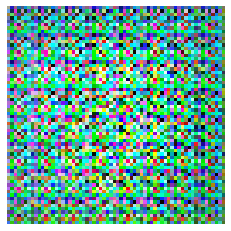

--- EPOCH 65/100 ---
  0%|          | 0/1 [00:00<?, ?it/s]
dsc_real_scores.item()=17.02863883972168, dsc_fake_scores.item()=-16.766599655151367
100%|██████████| 1/1 [00:01<00:00,  1.21s/it]
Discriminator loss: -1.485650658607483
Generator loss:     24.544191360473633


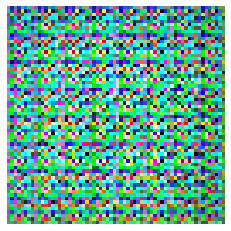

--- EPOCH 66/100 ---
  0%|          | 0/1 [00:00<?, ?it/s]
dsc_real_scores.item()=21.029056549072266, dsc_fake_scores.item()=-8.112060546875
100%|██████████| 1/1 [00:01<00:00,  1.21s/it]
Discriminator loss: -0.5954108834266663
Generator loss:     23.66777229309082


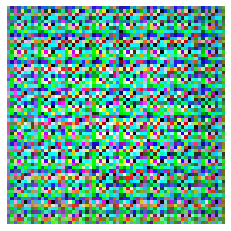

--- EPOCH 67/100 ---
  0%|          | 0/1 [00:00<?, ?it/s]
dsc_real_scores.item()=24.036718368530273, dsc_fake_scores.item()=-2.2592220306396484
100%|██████████| 1/1 [00:01<00:00,  1.30s/it]
Discriminator loss: 0.1273840218782425
Generator loss:     17.854690551757812


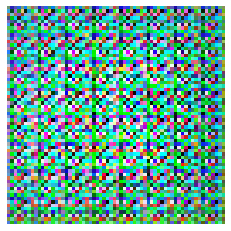

--- EPOCH 68/100 ---
  0%|          | 0/1 [00:00<?, ?it/s]
dsc_real_scores.item()=24.741500854492188, dsc_fake_scores.item()=-11.051279067993164
100%|██████████| 1/1 [00:01<00:00,  1.21s/it]
Discriminator loss: 2.7675271034240723
Generator loss:     13.330610275268555


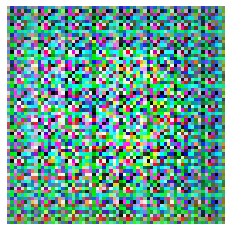

--- EPOCH 69/100 ---
  0%|          | 0/1 [00:00<?, ?it/s]
dsc_real_scores.item()=23.765003204345703, dsc_fake_scores.item()=-21.17706298828125
100%|██████████| 1/1 [00:01<00:00,  1.37s/it]
Discriminator loss: 0.33070826530456543
Generator loss:     17.165904998779297


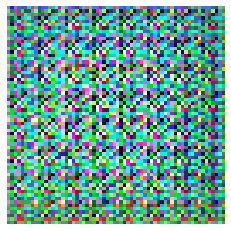

--- EPOCH 70/100 ---
  0%|          | 0/1 [00:00<?, ?it/s]
dsc_real_scores.item()=21.764419555664062, dsc_fake_scores.item()=-12.82491683959961
100%|██████████| 1/1 [00:01<00:00,  1.21s/it]
Discriminator loss: -0.5155864953994751
Generator loss:     6.5899200439453125


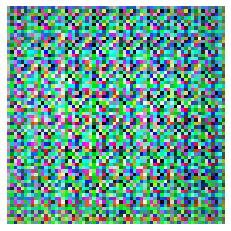

--- EPOCH 71/100 ---
  0%|          | 0/1 [00:00<?, ?it/s]
dsc_real_scores.item()=20.594146728515625, dsc_fake_scores.item()=-24.51856803894043
100%|██████████| 1/1 [00:01<00:00,  1.21s/it]
Discriminator loss: 2.051992893218994
Generator loss:     19.196121215820312


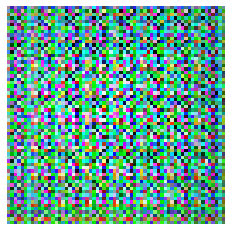

--- EPOCH 72/100 ---
  0%|          | 0/1 [00:00<?, ?it/s]
dsc_real_scores.item()=19.996578216552734, dsc_fake_scores.item()=-10.942752838134766
100%|██████████| 1/1 [00:01<00:00,  1.35s/it]
Discriminator loss: 1.2056461572647095
Generator loss:     2.3450868129730225


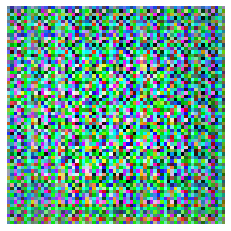

--- EPOCH 73/100 ---
  0%|          | 0/1 [00:00<?, ?it/s]
dsc_real_scores.item()=18.12343978881836, dsc_fake_scores.item()=-16.465829849243164
100%|██████████| 1/1 [00:01<00:00,  1.45s/it]
Discriminator loss: -0.8267834186553955
Generator loss:     7.788907527923584


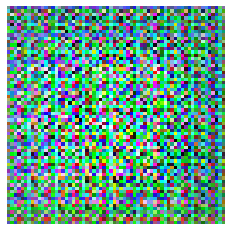

--- EPOCH 74/100 ---
  0%|          | 0/1 [00:00<?, ?it/s]
dsc_real_scores.item()=18.074222564697266, dsc_fake_scores.item()=-6.6441969871521
100%|██████████| 1/1 [00:01<00:00,  1.23s/it]
Discriminator loss: -0.8646256923675537
Generator loss:     26.46767234802246


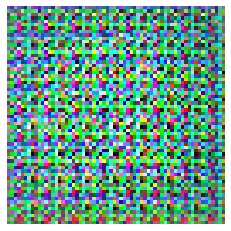

--- EPOCH 75/100 ---
  0%|          | 0/1 [00:00<?, ?it/s]
dsc_real_scores.item()=20.504894256591797, dsc_fake_scores.item()=-15.383246421813965
100%|██████████| 1/1 [00:01<00:00,  1.24s/it]
Discriminator loss: 1.4227136373519897
Generator loss:     5.225672721862793


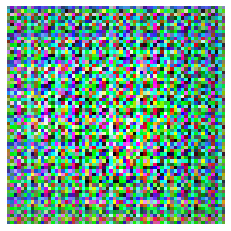

--- EPOCH 76/100 ---
  0%|          | 0/1 [00:00<?, ?it/s]
dsc_real_scores.item()=20.465402603149414, dsc_fake_scores.item()=-2.159071207046509
100%|██████████| 1/1 [00:01<00:00,  1.25s/it]
Discriminator loss: -0.38108325004577637
Generator loss:     1.9152512550354004


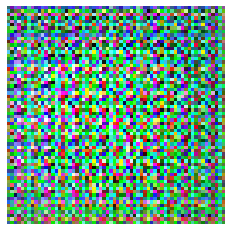

--- EPOCH 77/100 ---
  0%|          | 0/1 [00:00<?, ?it/s]
dsc_real_scores.item()=20.755502700805664, dsc_fake_scores.item()=6.982911586761475
100%|██████████| 1/1 [00:01<00:00,  1.15s/it]
Discriminator loss: 6.905636787414551
Generator loss:     24.13414764404297


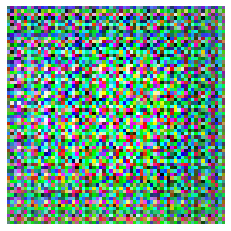

--- EPOCH 78/100 ---
  0%|          | 0/1 [00:00<?, ?it/s]
dsc_real_scores.item()=5.338884353637695, dsc_fake_scores.item()=-24.30032730102539
100%|██████████| 1/1 [00:01<00:00,  1.15s/it]
Discriminator loss: -2.533372640609741
Generator loss:     26.980701446533203


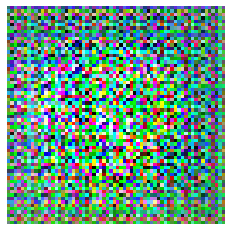

--- EPOCH 79/100 ---
  0%|          | 0/1 [00:00<?, ?it/s]
dsc_real_scores.item()=-2.371126174926758, dsc_fake_scores.item()=-26.42539405822754
100%|██████████| 1/1 [00:01<00:00,  1.19s/it]
Discriminator loss: 2.5756888389587402
Generator loss:     25.858875274658203


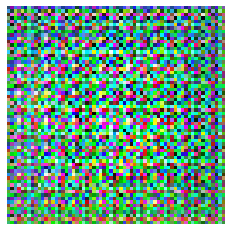

--- EPOCH 80/100 ---
  0%|          | 0/1 [00:00<?, ?it/s]
dsc_real_scores.item()=17.723411560058594, dsc_fake_scores.item()=-24.801530838012695
100%|██████████| 1/1 [00:01<00:00,  1.20s/it]
Discriminator loss: -2.5005943775177
Generator loss:     25.87251853942871


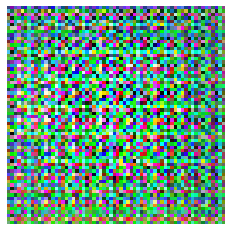

--- EPOCH 81/100 ---
  0%|          | 0/1 [00:00<?, ?it/s]
dsc_real_scores.item()=19.831195831298828, dsc_fake_scores.item()=-24.14618492126465
100%|██████████| 1/1 [00:01<00:00,  1.30s/it]
Discriminator loss: 0.0044558048248291016
Generator loss:     25.764116287231445


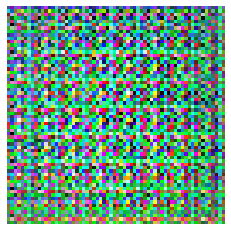

--- EPOCH 82/100 ---
  0%|          | 0/1 [00:00<?, ?it/s]
dsc_real_scores.item()=19.590295791625977, dsc_fake_scores.item()=-23.3472957611084
100%|██████████| 1/1 [00:01<00:00,  1.11s/it]
Discriminator loss: 0.5382511019706726
Generator loss:     23.86709213256836


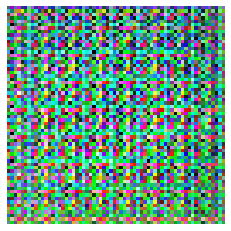

--- EPOCH 83/100 ---
  0%|          | 0/1 [00:00<?, ?it/s]
dsc_real_scores.item()=18.101770401000977, dsc_fake_scores.item()=-20.91627311706543
100%|██████████| 1/1 [00:01<00:00,  1.15s/it]
Discriminator loss: -3.5928664207458496
Generator loss:     22.88724136352539


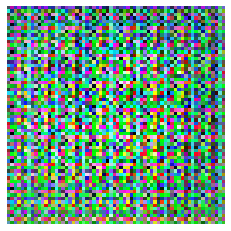

--- EPOCH 84/100 ---
  0%|          | 0/1 [00:00<?, ?it/s]
dsc_real_scores.item()=20.65262222290039, dsc_fake_scores.item()=-21.286640167236328
100%|██████████| 1/1 [00:01<00:00,  1.26s/it]
Discriminator loss: -0.5298548340797424
Generator loss:     26.86652374267578


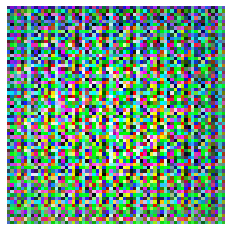

--- EPOCH 85/100 ---
  0%|          | 0/1 [00:00<?, ?it/s]
dsc_real_scores.item()=21.612028121948242, dsc_fake_scores.item()=-19.452171325683594
100%|██████████| 1/1 [00:01<00:00,  1.48s/it]
Discriminator loss: 0.3195086717605591
Generator loss:     17.690397262573242


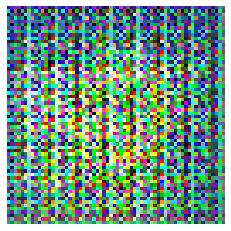

--- EPOCH 86/100 ---
  0%|          | 0/1 [00:00<?, ?it/s]
dsc_real_scores.item()=22.047748565673828, dsc_fake_scores.item()=-21.050092697143555
100%|██████████| 1/1 [00:01<00:00,  1.18s/it]
Discriminator loss: -1.3315582275390625
Generator loss:     1.7136991024017334


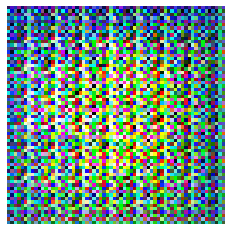

--- EPOCH 87/100 ---
  0%|          | 0/1 [00:00<?, ?it/s]
dsc_real_scores.item()=24.843280792236328, dsc_fake_scores.item()=3.503889322280884
100%|██████████| 1/1 [00:01<00:00,  1.29s/it]
Discriminator loss: 5.250223636627197
Generator loss:     29.515233993530273


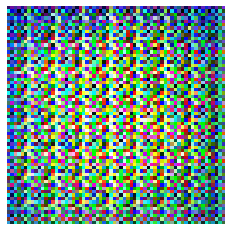

--- EPOCH 88/100 ---
  0%|          | 0/1 [00:00<?, ?it/s]
dsc_real_scores.item()=7.094984531402588, dsc_fake_scores.item()=-26.546241760253906
100%|██████████| 1/1 [00:01<00:00,  1.17s/it]
Discriminator loss: 0.48082655668258667
Generator loss:     30.09131622314453


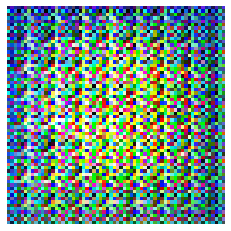

--- EPOCH 89/100 ---
  0%|          | 0/1 [00:00<?, ?it/s]
dsc_real_scores.item()=-2.134432077407837, dsc_fake_scores.item()=-29.64917755126953
100%|██████████| 1/1 [00:01<00:00,  1.16s/it]
Discriminator loss: 0.6784424781799316
Generator loss:     25.88552474975586


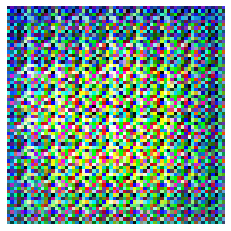

--- EPOCH 90/100 ---
  0%|          | 0/1 [00:00<?, ?it/s]
dsc_real_scores.item()=22.960643768310547, dsc_fake_scores.item()=-29.1070556640625
100%|██████████| 1/1 [00:01<00:00,  1.29s/it]
Discriminator loss: -4.782079696655273
Generator loss:     25.664304733276367


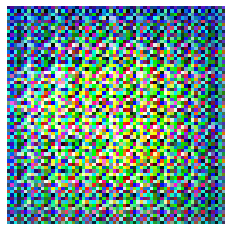

--- EPOCH 91/100 ---
  0%|          | 0/1 [00:00<?, ?it/s]
dsc_real_scores.item()=26.161827087402344, dsc_fake_scores.item()=-27.10541534423828
100%|██████████| 1/1 [00:01<00:00,  1.19s/it]
Discriminator loss: 1.7984669208526611
Generator loss:     18.04762077331543


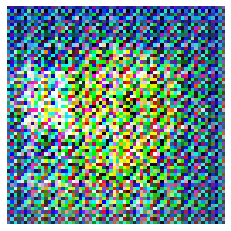

--- EPOCH 92/100 ---
  0%|          | 0/1 [00:00<?, ?it/s]
dsc_real_scores.item()=27.592208862304688, dsc_fake_scores.item()=-2.5637366771698
100%|██████████| 1/1 [00:01<00:00,  1.14s/it]
Discriminator loss: 2.5251340866088867
Generator loss:     21.898296356201172


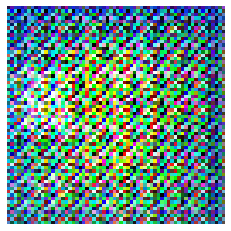

--- EPOCH 93/100 ---
  0%|          | 0/1 [00:00<?, ?it/s]
dsc_real_scores.item()=26.690593719482422, dsc_fake_scores.item()=-21.909700393676758
100%|██████████| 1/1 [00:01<00:00,  1.18s/it]
Discriminator loss: -0.3724684715270996
Generator loss:     16.37026596069336


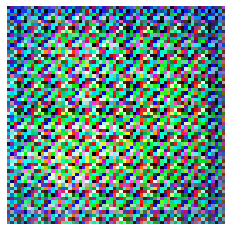

--- EPOCH 94/100 ---
  0%|          | 0/1 [00:00<?, ?it/s]
dsc_real_scores.item()=27.181392669677734, dsc_fake_scores.item()=-25.229808807373047
100%|██████████| 1/1 [00:01<00:00,  1.16s/it]
Discriminator loss: -1.4078295230865479
Generator loss:     7.07927942276001


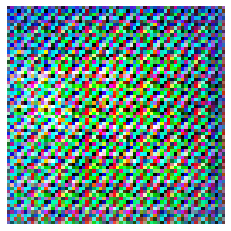

--- EPOCH 95/100 ---
  0%|          | 0/1 [00:00<?, ?it/s]
dsc_real_scores.item()=28.37242317199707, dsc_fake_scores.item()=-6.853846549987793
100%|██████████| 1/1 [00:01<00:00,  1.30s/it]
Discriminator loss: -1.6873482465744019
Generator loss:     10.381937980651855


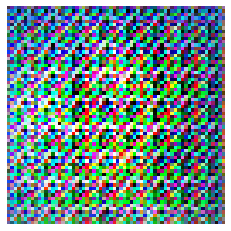

--- EPOCH 96/100 ---
  0%|          | 0/1 [00:00<?, ?it/s]
dsc_real_scores.item()=29.44862174987793, dsc_fake_scores.item()=12.438993453979492
100%|██████████| 1/1 [00:01<00:00,  1.19s/it]
Discriminator loss: 15.740989685058594
Generator loss:     25.428327560424805


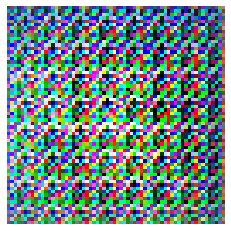

--- EPOCH 97/100 ---
  0%|          | 0/1 [00:00<?, ?it/s]
dsc_real_scores.item()=16.205034255981445, dsc_fake_scores.item()=-22.959882736206055
100%|██████████| 1/1 [00:01<00:00,  1.18s/it]
Discriminator loss: -0.7207212448120117
Generator loss:     27.394071578979492


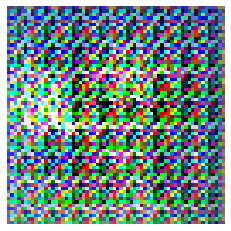

--- EPOCH 98/100 ---
  0%|          | 0/1 [00:00<?, ?it/s]
dsc_real_scores.item()=5.644817352294922, dsc_fake_scores.item()=-27.04633903503418
100%|██████████| 1/1 [00:01<00:00,  1.30s/it]
Discriminator loss: -1.9676088094711304
Generator loss:     28.098567962646484


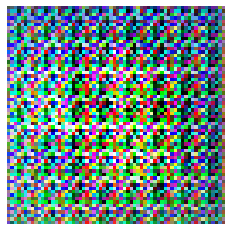

--- EPOCH 99/100 ---
  0%|          | 0/1 [00:00<?, ?it/s]
dsc_real_scores.item()=-2.8128178119659424, dsc_fake_scores.item()=-27.567079544067383
100%|██████████| 1/1 [00:01<00:00,  1.26s/it]
Discriminator loss: 4.73484992980957
Generator loss:     22.3836669921875


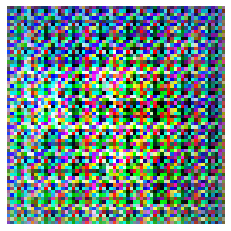

--- EPOCH 100/100 ---
  0%|          | 0/1 [00:00<?, ?it/s]
dsc_real_scores.item()=22.87539291381836, dsc_fake_scores.item()=-24.72430419921875
100%|██████████| 1/1 [00:01<00:00,  1.17s/it]
Discriminator loss: -0.12808763980865479
Generator loss:     22.588834762573242


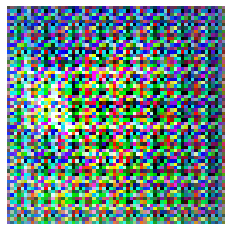

In [27]:
import IPython.display
import tqdm
from hw3.gan import train_batch, save_checkpoint


num_epochs = 100
try:
    dsc_avg_losses, gen_avg_losses = [], []
    for epoch_idx in range(num_epochs):
        # We'll accumulate batch losses and show an average once per epoch.
        dsc_losses, gen_losses = [], []
        print(f'--- EPOCH {epoch_idx+1}/{num_epochs} ---')

        with tqdm.tqdm(total=len(dl_gwb_s.batch_sampler), file=sys.stdout) as pbar:
            for batch_idx, (x_data, _) in enumerate(dl_gwb_s):
                x_data = x_data.to(device)
                dsc_loss, gen_loss = train_batch(
                    dsc, gen,
                    dsc_loss_fn, gen_loss_fn,
                    dsc_optimizer, gen_optimizer,
                    x_data)
                dsc_losses.append(dsc_loss)
                gen_losses.append(gen_loss)
                pbar.update()

        dsc_avg_losses.append(np.mean(dsc_losses))
        gen_avg_losses.append(np.mean(gen_losses))
        print(f'Discriminator loss: {dsc_avg_losses[-1]}')
        print(f'Generator loss:     {gen_avg_losses[-1]}')
        fig, _ = plot.tensor_as_image(gen.sample(1, with_grad=False))
        IPython.display.display(fig)
        plt.close(fig)
except KeyboardInterrupt as e:
    print('\n *** Training interrupted by user')


(<Figure size 576x576 with 5 Axes>,
 array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>], dtype=object))

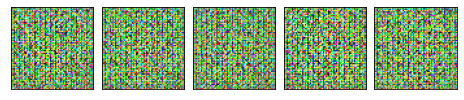

In [41]:
samples = gen.sample(5, with_grad=False)
plot.tensors_as_images(samples.cpu())

### Finish overfit

**TODO**:
1. Implement the `train_batch` function in the `hw3/gan.py` module.
2. Tweak the hyperparameters in the `part3_gan_hyperparams()` function within the `hw3/answers.py` module.

In [34]:
import torch.optim as optim
from torch.utils.data import DataLoader
from hw3.answers import part3_gan_hyperparams

torch.manual_seed(42)

# Hyperparams
hp = part3_gan_hyperparams()
batch_size = hp['batch_size']
z_dim = hp['z_dim']

# Data
dl_train = DataLoader(ds_gwb, batch_size, shuffle=True)
im_size = ds_gwb[0][0].shape

# Model
dsc = gan.Discriminator(im_size).to(device)
gen = gan.Generator(z_dim, featuremap_size=4).to(device)

# Optimizer
def create_optimizer(model_params, opt_params):
    opt_params = opt_params.copy()
    optimizer_type = opt_params['type']
    opt_params.pop('type')
    return optim.__dict__[optimizer_type](model_params, **opt_params)
dsc_optimizer = create_optimizer(dsc.parameters(), hp['discriminator_optimizer'])
gen_optimizer = create_optimizer(gen.parameters(), hp['generator_optimizer'])

# Loss
def dsc_loss_fn(y_data, y_generated):
    return gan.discriminator_loss_fn(y_data, y_generated, hp['data_label'], hp['label_noise'])

def gen_loss_fn(y_generated):
    return gan.generator_loss_fn(y_generated, hp['data_label'])

# Training
checkpoint_file = 'checkpoints/gan'
checkpoint_file_final = f'{checkpoint_file}_final'
if os.path.isfile(f'{checkpoint_file}.pt'):
    os.remove(f'{checkpoint_file}.pt')

# Show hypers
print(hp)

{'batch_size': 64, 'z_dim': 100, 'data_label': 0, 'label_noise': 0.2, 'discriminator_optimizer': {'type': 'SGD', 'lr': 0.0001, 'momentum': 0.9}, 'generator_optimizer': {'type': 'Adam', 'lr': 0.0001, 'betas': (0.9, 0.99)}}


**TODO**:
1. Implement the `save_checkpoint` function in the `hw3.gan` module. You can decide on your own criterion regarding whether to save a checkpoint at the end of each epoch.
1. Run the following block to train. It will sample some images from your model every few epochs so you can see the progress.
2. When you're satisfied with your results, rename the checkpoints file by adding `_final`. When you run the `main.py` script to generate your submission, the final checkpoints file will be loaded instead of running training. Note that your final submission zip will not include the `checkpoints/` folder. This is OK.

In [33]:
import IPython.display
import tqdm
from hw3.gan import train_batch, save_checkpoint

num_epochs = 100

if os.path.isfile(f'{checkpoint_file_final}.pt'):
    print(f'*** Loading final checkpoint file {checkpoint_file_final} instead of training')
    num_epochs = 0
    gen = torch.load(f'{checkpoint_file_final}.pt', map_location=device,)
    checkpoint_file = checkpoint_file_final

try:
    dsc_avg_losses, gen_avg_losses = [], []
    for epoch_idx in range(num_epochs):
        # We'll accumulate batch losses and show an average once per epoch.
        dsc_losses, gen_losses = [], []
        print(f'--- EPOCH {epoch_idx+1}/{num_epochs} ---')

        with tqdm.tqdm(total=len(dl_train.batch_sampler), file=sys.stdout) as pbar:
            for batch_idx, (x_data, _) in enumerate(dl_train):
                x_data = x_data.to(device)
                dsc_loss, gen_loss = train_batch(
                    dsc, gen,
                    dsc_loss_fn, gen_loss_fn,
                    dsc_optimizer, gen_optimizer,
                    x_data)
                dsc_losses.append(dsc_loss)
                gen_losses.append(gen_loss)
                pbar.update()

        dsc_avg_losses.append(np.mean(dsc_losses))
        gen_avg_losses.append(np.mean(gen_losses))
        print(f'Discriminator loss: {dsc_avg_losses[-1]}')
        print(f'Generator loss:     {gen_avg_losses[-1]}')
        
        if save_checkpoint(gen, dsc_avg_losses, gen_avg_losses, checkpoint_file):
            print(f'Saved checkpoint.')
            

        samples = gen.sample(5, with_grad=False)
        fig, _ = plot.tensors_as_images(samples.cpu(), figsize=(6,2))
        IPython.display.display(fig)
        plt.close(fig)
except KeyboardInterrupt as e:
    print('\n *** Training interrupted by user')

--- EPOCH 1/100 ---
  0%|          | 0/9 [00:05<?, ?it/s]

 *** Training interrupted by user


In [ ]:
# Plot images from best or last model
if os.path.isfile(f'{checkpoint_file}.pt'):
    gen = torch.load(f'{checkpoint_file}.pt', map_location=device)
print('*** Images Generated from best model:')
samples = gen.sample(n=15, with_grad=False).cpu()
fig, _ = plot.tensors_as_images(samples, nrows=3, figsize=(6,6))

## Questions
<a id=part3_8></a>

**TODO** Answer the following questions. Write your answers in the appropriate variables in the module `hw3/answers.py`.

In [ ]:
from cs236781.answers import display_answer
import hw3.answers as answers

### Question 1

Explain in detail why during training we sometimes need to maintain gradients when sampling from the GAN,
and other times we don't. When are they maintained and why? When are they discarded and why?

In [ ]:
display_answer(answers.part3_q1)


### Question 2

1. When training a GAN to generate images, should we decide to stop training solely based on the fact that  the Generator loss is below some threshold?
Why or why not?

2. What does it mean if the discriminator loss remains at a constant value while the generator loss decreases?

In [ ]:
display_answer(answers.part3_q2)

### Question 3

Compare the results you got when generating images with the VAE to the GAN results.
What's the main difference and what's causing it?

In [ ]:
display_answer(answers.part3_q3)
